# 积累偏差
加速度计通常会出现 **偏差** 。这意味着即使加速度为零，它们也会测量到一些非零值。 通过仔细校准（并购买更好的传感器）可以减少偏差，但很难完全消除偏差。

在这个 notebook 中，你将简要探讨偏差是如何积累的。

----

## 第1部分 - 什么是偏差？
当传感器的读数持续过高或过低时，它就会产生偏差。还记得电梯加速度数据吗？

下面的代码与你用来绘制数据曲线图的代码类似。

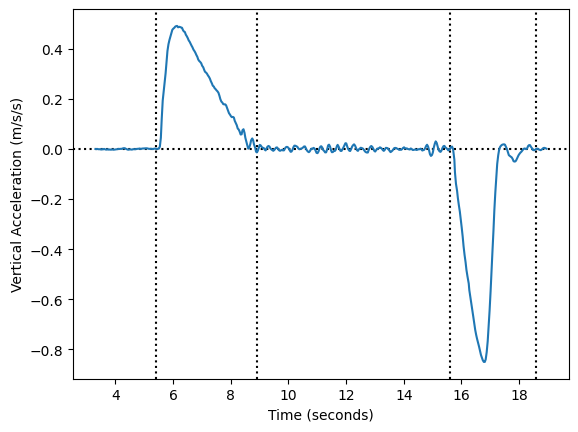

In [3]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# get elevator data
data = np.genfromtxt("elevator-lac.csv", delimiter=",")[100:570]

# unpack that data
t, a_x, a_y, a_z = data.T
plt.ylabel("Vertical Acceleration (m/s/s)")
plt.xlabel("Time (seconds)")
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.axhline(y=0, color='black',linestyle='dotted')
# plt.plot(t, a_z) 
plt.plot(t, a_z + 0.12) 
plt.show()

需要注意的是，该图的平坦部分（0加速度）没有与点 $a=0$ 线对齐。但它们本应该与之对齐的！

这个偏移是由于加速度计中的 **偏差** 造成的。

如果我们知道存在偏差，我们可以手动进行纠正。

**TODO - 纠正偏差**
> 将上面代码单元中的第二行代码更改为以下代码
> ```python
> plt.plot(t, a_z+0.12) 
> ```
> 然后重新运行该单元格。

## 第2部分 - 将偏差对 `离散` 数据的影响可视化 116号 2 304

### 用偏差重新编写`get_integral_from_data` 函数

在下面的代码单元格中，你将看到我如何重写此函数，使其包含一个 **可选** 的第三个参数 `bias`。 此参数的默认值为零。

当这个参数非零时，它会模拟（或纠正）数据中的偏移量。

In [4]:
def get_integral_from_data(acceleration_data, times, bias=0.0):
    """
    Numerically integrates data AND artificially introduces 
    bias to that data.
    
    Note that the bias parameter can also be used to offset
    a biased sensor.
    """
    accumulated_speed = 0.0
    last_time = times[0]
    speeds = []
    for i in range(1, len(times)):
        
        # THIS is where the bias is introduced. No matter what the 
        # real acceleration is, this biased accelerometer adds 
        # some bias to the reported value.
        acceleration = acceleration_data[i] + bias
        
        time = times[i]
        delta_t = time - last_time
        delta_v = acceleration * delta_t
        accumulated_speed += delta_v
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

**TODO - 绘制在有无偏差情况下的速度和加速度曲线图**

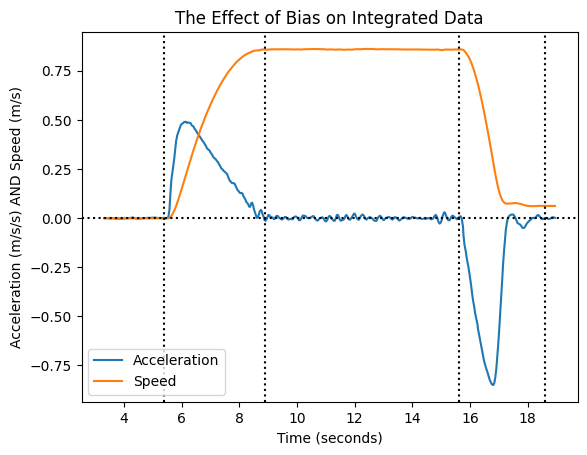

In [7]:
# TODO 
#   0. read through the code below to get a sense for what it does.
#   1. run this cell with OFFSET = 0.0
#   2. look at the graph. Note how drastic the error is with the
#      integrated speed! 
#   3. change OFFSET to OFFSET = 0.12 and re-run the cell

# OFFSET = 0.0
OFFSET = 0.12

plt.title("The Effect of Bias on Integrated Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s/s) AND Speed (m/s)")

# get the elevator speeds by integrating the acceleration data
elevator_speeds = get_integral_from_data(a_z, t, OFFSET)

# plot acceleration data
plt.plot(t, a_z+OFFSET) 

# plot INFERRED (from integration) speed data
plt.plot(t[1:], elevator_speeds)

# add a legend to the plot
plt.legend(["Acceleration", "Speed"])

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

# a=0 reference line
plt.axhline(y=0, color='black',linestyle='dotted')

plt.show()

当`OFFSET = 0.0`时，速度曲线图看起来很荒唐！ 它显示，在旅程结束时，电梯的速度是-1.8米/秒（显然它应该是0.0）。

请注意，随着时间的推移，偏差的影响会变得越来越大（对于速度曲线图来说）！

当 `OFFSET = 0.12`时，这个图虽然仍然不完美，但看起来更合理。

> 当积分发生很长一段时间时，我们应对集成数据持更加怀疑的态度。

## 第3部分 - 重复积分的影响

当我们给数据时间积累时，你会发现这种偏差会对积分数据产生更大的影响。 如果我们积分 **两次**，会发生什么情况呢？

In [9]:
# This is just a helper function for integrating twice.
def double_integral(data, times, bias=0.0):
    print(bias)
    speeds = get_integral_from_data(data, times, bias)
    displacements = get_integral_from_data(speeds, times[1:])
    return displacements

**TODO  - 观察偏差对双重积分的影响**

> 1. 运行下面的单元格（OFFSET = 0.12）。它表明电梯上升到约8米的高度。
> 2. 将OFFSET更改为0.0并重新运行。看看这个推断的位置有多糟糕！ 看起来我们实际上已经在下降了。

0.0


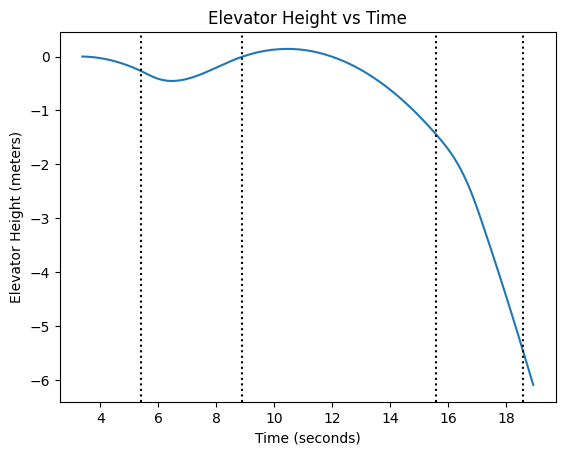

In [10]:
OFFSET = 0.12
OFFSET = 0.0

plt.title("Elevator Height vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Elevator Height (meters)")

displacements = double_integral(a_z, t, OFFSET)
plt.plot(t[2:], displacements)

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.show()

## 第4部分 - 并行停车

相同的练习，不同的数据。请注意，这次的加速计是“完美的”（因为这里的数据是假的），我们将使用`bias`参数来*引入* 偏差（而不是纠正它）。

In [12]:
from helpers import process_data

PARALLEL_PARK_DATA = process_data("parallel_park.pickle")

TIMESTAMPS    = [row[0] for row in PARALLEL_PARK_DATA]
DISPLACEMENTS = [row[1] for row in PARALLEL_PARK_DATA]
YAW_RATES     = [row[2] for row in PARALLEL_PARK_DATA]
ACCELERATIONS = [row[3] for row in PARALLEL_PARK_DATA]

#### 观察偏差的影响
运行下面的代码单元格。你会发现，当偏差很小（如0.01）时，加速度计读出的加速度（蓝点）与实际加速度（橙色点）非常吻合。

当偏差增加时，情况会很快变得很糟糕！

0.01


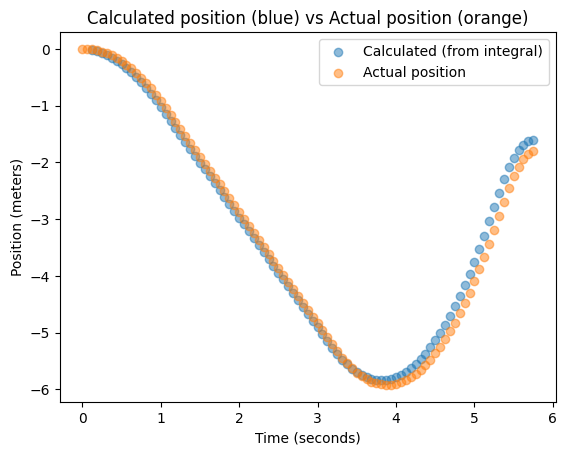

In [14]:
# Try running this cell with BIAS set to 0.01, 0.05, 0.1, 0.2, 0.4
# and so on. Even though these are all small numbers the effect of 
# bias tends to accumulate as the sensor runs for longer and longer.

BIAS = 0.01

integrated_displacements = double_integral(ACCELERATIONS, TIMESTAMPS, BIAS)

plt.title("Calculated position (blue) vs Actual position (orange)")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (meters)")
plt.scatter(TIMESTAMPS[2:], integrated_displacements, alpha=0.5)
plt.scatter(TIMESTAMPS, DISPLACEMENTS, alpha=0.5)
plt.legend(["Calculated (from integral)", "Actual position"])
plt.show()